In [26]:
#importing libraries
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from random import shuffle
from sklearn.metrics import roc_auc_score

In [3]:
#HyperParameters
epochs = 5
step_size = 4
IMG_SIZE_ALEXNET = 227 # image size
validating_size = 89 # while cross validating, we are evaluating batch by batch
nodes_fc1 = 4096 # no of nodes on fc layer 1
nodes_fc2 = 4096 # no of nodes on fc layer 2
output_locations = 4 # minx, miny, maxx, maxy

In [4]:
#Loading test data to be predicted.
X_test = np.load('object_localization_x_test.npy')

In [5]:
len(X_test)

12815

In [6]:
#Resetting graph
tf.reset_default_graph()

In [7]:
#Defining Placeholders
x = tf.placeholder(tf.float32,shape=[None,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3])
y_true_2 = tf.placeholder(tf.float32,shape=[None,output_locations])

In [8]:
##CONVOLUTION LAYER 1
#Weights for layer 1
w_1 = tf.Variable(tf.truncated_normal([11,11,3,96], stddev=0.01))
#Bias for layer 1
b_1 = tf.Variable(tf.constant(0.0, shape=[96]))
#Applying convolution
c_1 = tf.nn.conv2d(x, w_1,strides=[1, 4, 4, 1], padding='VALID')
#Adding bias
c_1 = c_1 + b_1
#Applying RELU
c_1 = tf.nn.relu(c_1)
print(c_1)

Tensor("Relu:0", shape=(?, 55, 55, 96), dtype=float32)


In [9]:
##POOLING LAYER1
p_1 = tf.nn.max_pool(c_1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_1)

Tensor("MaxPool:0", shape=(?, 27, 27, 96), dtype=float32)


In [10]:
##CONVOLUTION LAYER 2
#Weights for layer 2
w_2 = tf.Variable(tf.truncated_normal([5,5,96,256], stddev=0.01))
#Bias for layer 2
b_2 = tf.Variable(tf.constant(1.0, shape=[256]))
#Applying convolution
c_2 = tf.nn.conv2d(p_1, w_2,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_2 = c_2 + b_2
#Applying RELU
c_2 = tf.nn.relu(c_2)
print(c_2)

Tensor("Relu_1:0", shape=(?, 27, 27, 256), dtype=float32)


In [11]:
##POOLING LAYER2
p_2 = tf.nn.max_pool(c_2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_2)

Tensor("MaxPool_1:0", shape=(?, 13, 13, 256), dtype=float32)


In [12]:
##CONVOLUTION LAYER 3
#Weights for layer 3
w_3 = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=0.01))
#Bias for layer 3
b_3 = tf.Variable(tf.constant(0.0, shape=[384]))
#Applying convolution
c_3 = tf.nn.conv2d(p_2, w_3,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_3 = c_3 + b_3
#Applying RELU
c_3 = tf.nn.relu(c_3)
print(c_3)

Tensor("Relu_2:0", shape=(?, 13, 13, 384), dtype=float32)


In [13]:
##CONVOLUTION LAYER 4
#Weights for layer 4
w_4 = tf.Variable(tf.truncated_normal([3, 3, 384, 384], stddev=0.01))
#Bias for layer 4
b_4 = tf.Variable(tf.constant(0.0, shape=[384]))
#Applying convolution
c_4 = tf.nn.conv2d(c_3, w_4,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_4 = c_4 + b_4
#Applying RELU
c_4 = tf.nn.relu(c_4)
print(c_4)

Tensor("Relu_3:0", shape=(?, 13, 13, 384), dtype=float32)


In [14]:
##CONVOLUTION LAYER 5
#Weights for layer 5
w_5 = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=0.01))
#Bias for layer 5
b_5 = tf.Variable(tf.constant(0.0, shape=[256]))
#Applying convolution
c_5 = tf.nn.conv2d(c_4, w_5,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_5 = c_5 + b_5
#Applying RELU
c_5 = tf.nn.relu(c_5)
print(c_5)

Tensor("Relu_4:0", shape=(?, 13, 13, 256), dtype=float32)


In [15]:
##POOLING LAYER3
p_3 = tf.nn.max_pool(c_5, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_3)

Tensor("MaxPool_2:0", shape=(?, 6, 6, 256), dtype=float32)


In [16]:
#Flattening
flattened = tf.reshape(p_3,[-1,6*6*256])
print(flattened)

Tensor("Reshape:0", shape=(?, 9216), dtype=float32)


In [17]:
##Fully Connected Layer 1
#Getting input nodes in FC layer 1
input_size = int( flattened.get_shape()[1] )
#Weights for FC Layer 1
w1_fc = tf.Variable(tf.truncated_normal([input_size, nodes_fc1], stddev=0.01))
#Bias for FC Layer 1
b1_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc1] ) )
#Summing Matrix calculations and bias
s_fc1 = tf.matmul(flattened, w1_fc) + b1_fc
#Applying RELU
s_fc1 = tf.nn.relu(s_fc1)

In [18]:
#Dropout Layer 1
hold_prob1 = tf.placeholder(tf.float32)
s_fc1 = tf.nn.dropout(s_fc1,keep_prob=hold_prob1)
print(s_fc1)

Tensor("dropout/mul:0", shape=(?, 4096), dtype=float32)


In [19]:
##Fully Connected Layer 2
#Weights for FC Layer 2
w2_fc = tf.Variable(tf.truncated_normal([nodes_fc1, nodes_fc2], stddev=0.01))
#Bias for FC Layer 2
b2_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc2] ) )
#Summing Matrix calculations and bias
s_fc2 = tf.matmul(s_fc1, w2_fc) + b2_fc
#Applying RELU
s_fc2 = tf.nn.relu(s_fc2)
print(s_fc2)

Tensor("Relu_6:0", shape=(?, 4096), dtype=float32)


In [20]:
#Dropout Layer 2
hold_prob2 = tf.placeholder(tf.float32)
s_fc2 = tf.nn.dropout(s_fc2,keep_prob=hold_prob2)

In [21]:
##Fully Connected Layer 3 -- REGRESSION HEAD
#Weights for FC Layer 3
w3_fc_2 = tf.Variable(tf.truncated_normal([nodes_fc2,output_locations], stddev=0.01))
#Bias for FC Layer 3b3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
b3_fc_2 = tf.Variable( tf.constant(1.0, shape=[output_locations] ) )
#Summing Matrix calculations and bias
y_pred_2 = tf.matmul(s_fc2, w3_fc_2) + b3_fc_2
#Applying RELU
print(y_pred_2)

Tensor("add_7:0", shape=(?, 4), dtype=float32)


In [22]:
test_photos = X_test

In [23]:
from PIL import Image
import matplotlib.patches as patches
with tf.Session() as session:
    new_saver = tf.train.Saver()
    new_saver.restore(session, "CNN_final.ckpt")
    print("Model restored.") 
    print('Initialized')
    steps = int(len(X_test)/1000)
    remaining = len(X_test)%1000
    l = []
    for i in range(steps):
        temp = session.run([y_pred_2], feed_dict={x: test_photos[i*1000:(i+1)*1000], hold_prob1:1,hold_prob2:1})
        l.append(temp[0])
        print("Step ",i," ====> Completed")
    temp = session.run([y_pred_2], feed_dict={x: test_photos[steps*1000:], hold_prob1:1,hold_prob2:1})
    l.append(temp[0])
print(len(l))

INFO:tensorflow:Restoring parameters from CNN_final.ckpt
Model restored.
Initialized
Step  0  ====> Completed
Step  1  ====> Completed
Step  2  ====> Completed
Step  3  ====> Completed
Step  4  ====> Completed
Step  5  ====> Completed
Step  6  ====> Completed
Step  7  ====> Completed
Step  8  ====> Completed
Step  9  ====> Completed
Step  10  ====> Completed
Step  11  ====> Completed
13


In [24]:
l[12].shape
m = []
steps = len(l)
for i in range(steps):
    for j in range(l[i].shape[0]):
        m.append(l[i][j])
len(m)

12815

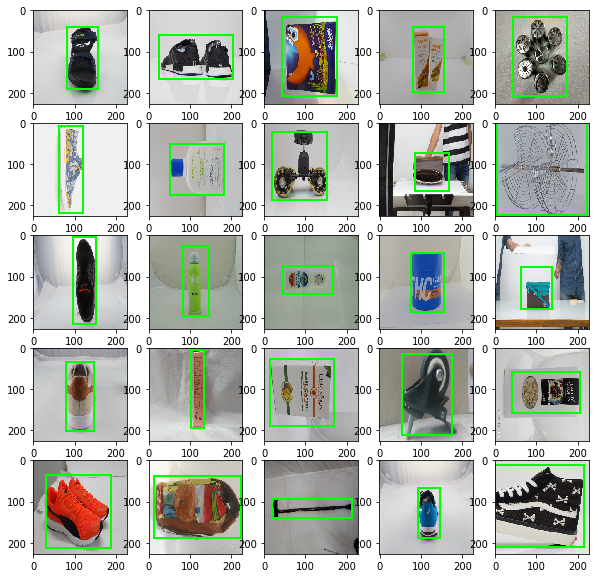

Testing finished


In [33]:
#visualising few images with its bounding box.
fig = plt.figure(figsize = (10,10))
for n in range(25):
    ax = fig.add_subplot(5,5,n+1)
    img = test_photos[n].reshape([IMG_SIZE_ALEXNET, IMG_SIZE_ALEXNET, 3])
    # Display the image
    ax.imshow(img)
    # Create a Rectangle patch
    rect = patches.Rectangle((m[n][0],m[n][2]),m[n][1]-m[n][0],m[n][3]-m[n][2],linewidth=2,edgecolor='lime',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()
print("Testing finished")

In [24]:
#dataframe of predicted coordinates
l = pd.DataFrame(m)
l.columns = ['x1','x2','y1','y2']
l

,x1,x2,y1,y2
0,82.558380,156.981552,39.042030,190.082596
1,25.257467,204.069962,60.759243,165.442902
2,44.267998,175.250076,16.617130,206.835892
3,79.993240,156.311325,39.092625,196.783554
4,42.753998,175.287613,15.522932,207.991043
5,61.242310,120.546707,6.940549,218.754379
6,51.238911,182.429199,50.656055,174.215744
7,19.988594,152.027451,21.293835,187.270508
8,85.444275,167.204086,73.740005,166.197464
9,5.856852,222.099228,-2.260328,223.639557


In [25]:
#rescaling to the original size(640*480)
l['x1'] *= (640/227)
l['x2'] *= (640/227)
l['y1'] *= (480/227)
l['y2'] *= (480/227)

In [26]:
#reading test image name and concatinating these with thier respective coordinates
test=pd.read_csv('test.csv')
names = pd.DataFrame(test['image_name'])
y_pred = pd.concat([names, l], axis=1, sort=False)
y_pred

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,232.763715,442.591160,82.555835,401.936767
1,1473231475010DeeplearnS11276.png,71.210480,575.351433,128.477694,349.835210
2,JPEG_20161205_135307_1000155917326.png,124.808452,494.097131,35.137544,437.362238
3,JPEG_20160711_123440_1000518778437.png,225.531603,440.701533,82.662819,416.106194
4,JPEG_20160803_115329_100034020722.png,120.539906,494.202962,32.823821,439.804849
5,147444974116511473239803010-Mast--Harbour-Men-...,172.665542,339.867368,14.676052,462.564326
6,JPEG_20160622_110649_1000527459853.png,144.462127,514.337830,107.114126,368.385714
7,JPEG_20160823_120737_1000784898268.png,56.355507,428.623649,45.026611,395.990501
8,1480965956645IMG_3094.png,240.900158,471.412402,155.926003,351.430761
9,14732348976417a565e40d545452688130062b267a2d2.png,16.512709,626.182845,-4.779549,472.894217


In [27]:
#saving the final predictions as a csv file.
y_pred.to_csv('y_pred_3.csv',index=False)